# Polygon pixel planar trap

The following notebook presents initialization, simulation and analysis of ion crystals in polygon traps with Sion. 

Contents:

1) n-wire trap initialization  
2) Stability analysis of n-wire trap  
3) Simulation of 10 ions in n-wire trap, 2 species.  
4) Normal mode calculation  


In [1]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn


The minimum is (-5.55e-21, 29.6, 78.6)
Distance from RF-minimum: (0, 0, 0)
Secular frequencies: (0.8633, 6.21, 7.1) MHz
In directions
a: [ 1. -0.  0.] 
b: [0.         0.1218839  0.99254436] 
c: [ 0.         -0.99254436  0.1218839 ]
Angle of secular modes rotation alpha: 1.448608615169673


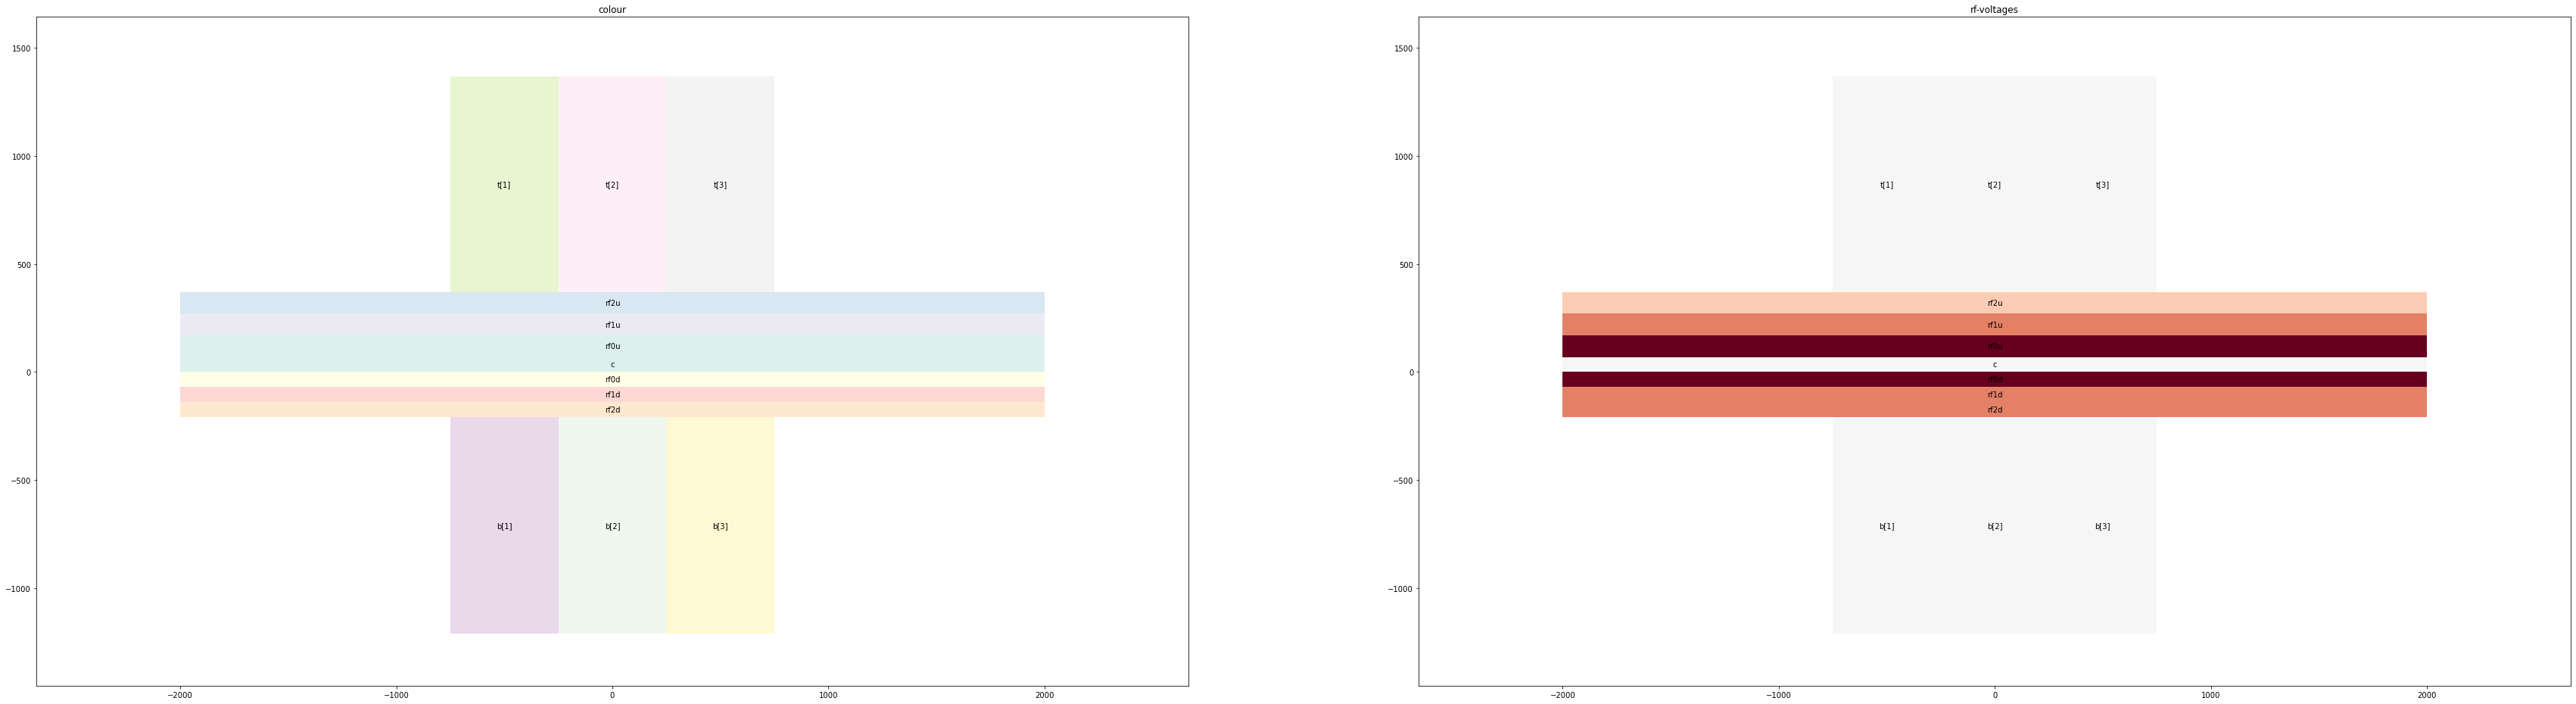

In [2]:
# Global definition of trap parameters. Used for all cells in this notebook
L = 1e-6 # µm length scale
Vrf = 100. # RF peak voltage in V
M = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)
scale = Z/((L*Omega)**2*M)


#parameters of trap
DCtop = [[1000,500]] #Array of lengths and widths of Top electrodes
DCbottom = [[1000,500]] #Array of lengths and widths of Bottom electrodes 
cwidth = 70  #Width of central dc electrode
rflength = 4000  #length of central dc, rf electrode
rfwidth = [[100, 70], [100, 70], [100, 70]]
patternTop = 3  #number of groups of Top dc electrodes, defined in DCtop. if None then = 1
patternBot = 3 #same for bottom dcs
cheight = 1000   #height of the grounded cover electrode plane 
cmax = 0  # order of the expansion of cover potential. if 0 - coder not considered, if 5 - considered with optimal precision
n_rf = 3
Urf = [[Urf, Urf], [Urf/2, Urf/2], [Urf/4, Urf/2]]

s, RF_electrodes, DC_electrodes = sn.n_rf_trap_design(Urf, DCtop, DCbottom, cwidth, rfwidth, rflength, n_rf = 3, L = 1e-6, patternTop=3, patternBot=3, need_plot = True)

x0 = s.minimum((0, 30.3, 79.4), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
#determine dc_set which doesn't change position of potential minimum
s1 = System([e for e in s if not e.rf])
# Give the constraints for system.shims
derivs = "xx x y z ".split()
u_cal = s1.shims((x0 , None, deriv) for deriv in derivs)
# Define variables for confinement in x-direction (uxx) and shim voltage sets (ux,uy,uz)
uxx = 1*np.array(u_cal[0])
ux = 1*np.array(u_cal[1])
uy = 1*np.array(u_cal[2])
uz = 1*np.array(u_cal[3])

dc_set = []
for i in range(len(DC_electrodes)):
    dc_set.append(uxx[i])
dc_set = 15*np.array(dc_set)/max(dc_set)
#dc_set = 1*np.array([ 5.05, -15.,     4.5,  15.,   -15.,    15.,    -0.1941])
u_set = np.append(np.zeros(2*n_rf), dc_set)
rf_set = [Vrf, Vrf, Vrf/2, Vrf/2, Vrf/4, Vrf/2]
omegas = [Omega]*6

with s.with_voltages(dcs = u_set, rfs = None):
    x1 = s.minimum(x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print('The minimum is (%.3g, %.3g, %.3g)' % (x1[0], x1[1], x1[2]))
    print('Distance from RF-minimum: (%.3g, %.3g, %.3g)' % (x1[0] - x0[0], x1[1] - x0[1], x1[2] - x0[2]))
    # Get trap frequencies
    try:
        curv_z, mod_dir=s.modes(x1,sorted=False)
        omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
        print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
        e1 = np.array([0,0,1])
        alp = np.arccos(np.inner(mod_dir[2],e1))
        print('Angle of secular modes rotation alpha:', alp)
    except:
        print("Secular frequencies not found")

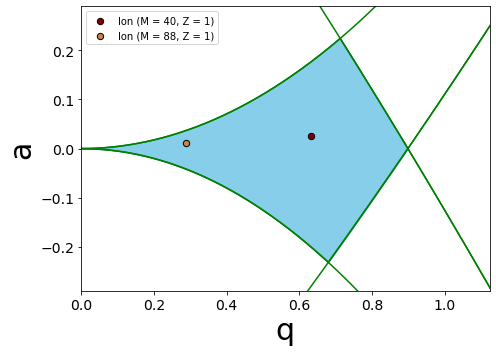

{'Ion (M = 40, Z = 1)': {'a': 0.024662973505457587, 'q': 0.6314549782077018},
 'Ion (M = 88, Z = 1)': {'a': 0.011210442502480721, 'q': 0.2870249900944099},
 'α': 1.1342938006713912,
 'θ': 0.017841244914865165,
 'Range of achievable a': [-0.23122990113976805, 0.22392743296940115],
 'Critical q': 0.8990495715685648}


In [3]:
with s.with_voltages(dcs = u_set, rfs = rf_set):
    params = sn.stability(s, [M, 88/40*M], Omega, [Z,Z], minimum = x1) 

import pprint
pprint.pprint(params, sort_dicts=False)

In [4]:
# simulation of ion crystal
Ca_ion_number = 8
Sr_ion_number = 2
x0 = x1*1e-6

#insert your path to this file here
name = Path('polygon_electrode_simulation.ipynb').stem

sim = pl.Simulation(name)

#ion declaration
Caions = {'mass': 40, 'charge': 1}
Srions = {'mass': 88, 'charge': 1}

#placing ions
Capositions = sn.ioncloud_min(x0, Ca_ion_number, 5e-6)
sim.append(pl.placeions(Caions, Capositions))
Srpositions = sn.ioncloud_min(x0, Sr_ion_number, 5e-6)
sim.append(pl.placeions(Srions, Srpositions))

#polygon trap initialization
sim.append(sn.polygon_trap(omegas, rf_set, dc_set, RF_electrodes, DC_electrodes))

#temperature and cooling
#sim.append(pl.thermalvelocities(2, False))
sim.append(pl.langevinbath(0, 5e-6))

#file with simulation information
sim.append(pl.dump('positions_polygon.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(2e5))
sim.execute()

Reducing timestep to 2.652582384864922e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  8 settings made for charge
8 atoms in group 1
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  2 settings made for charge
2 atoms in group 2
10 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none


C:\Users\a.podlesnyy\anaconda3\lib\site-packages\pylion-0.5.0-py3.8.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


Final ion positions:
 [[-8.70443e-06  2.97618e-05  7.79945e-05]
 [-7.45853e-06  2.87603e-05  7.54117e-05]
 [-4.87261e-06  2.94422e-05  7.89624e-05]
 [ 8.20181e-07  3.04258e-05  7.83561e-05]
 [ 2.98715e-06  2.89002e-05  8.02371e-05]
 [ 4.37831e-06  2.99025e-05  8.00942e-05]
 [ 6.31034e-06  2.96799e-05  8.06360e-05]
 [ 6.68706e-06  2.95223e-05  7.88487e-05]
 [ 1.27211e-05  2.90772e-05  8.00705e-05]
 [ 1.99005e-05  2.86785e-05  7.69796e-05]]


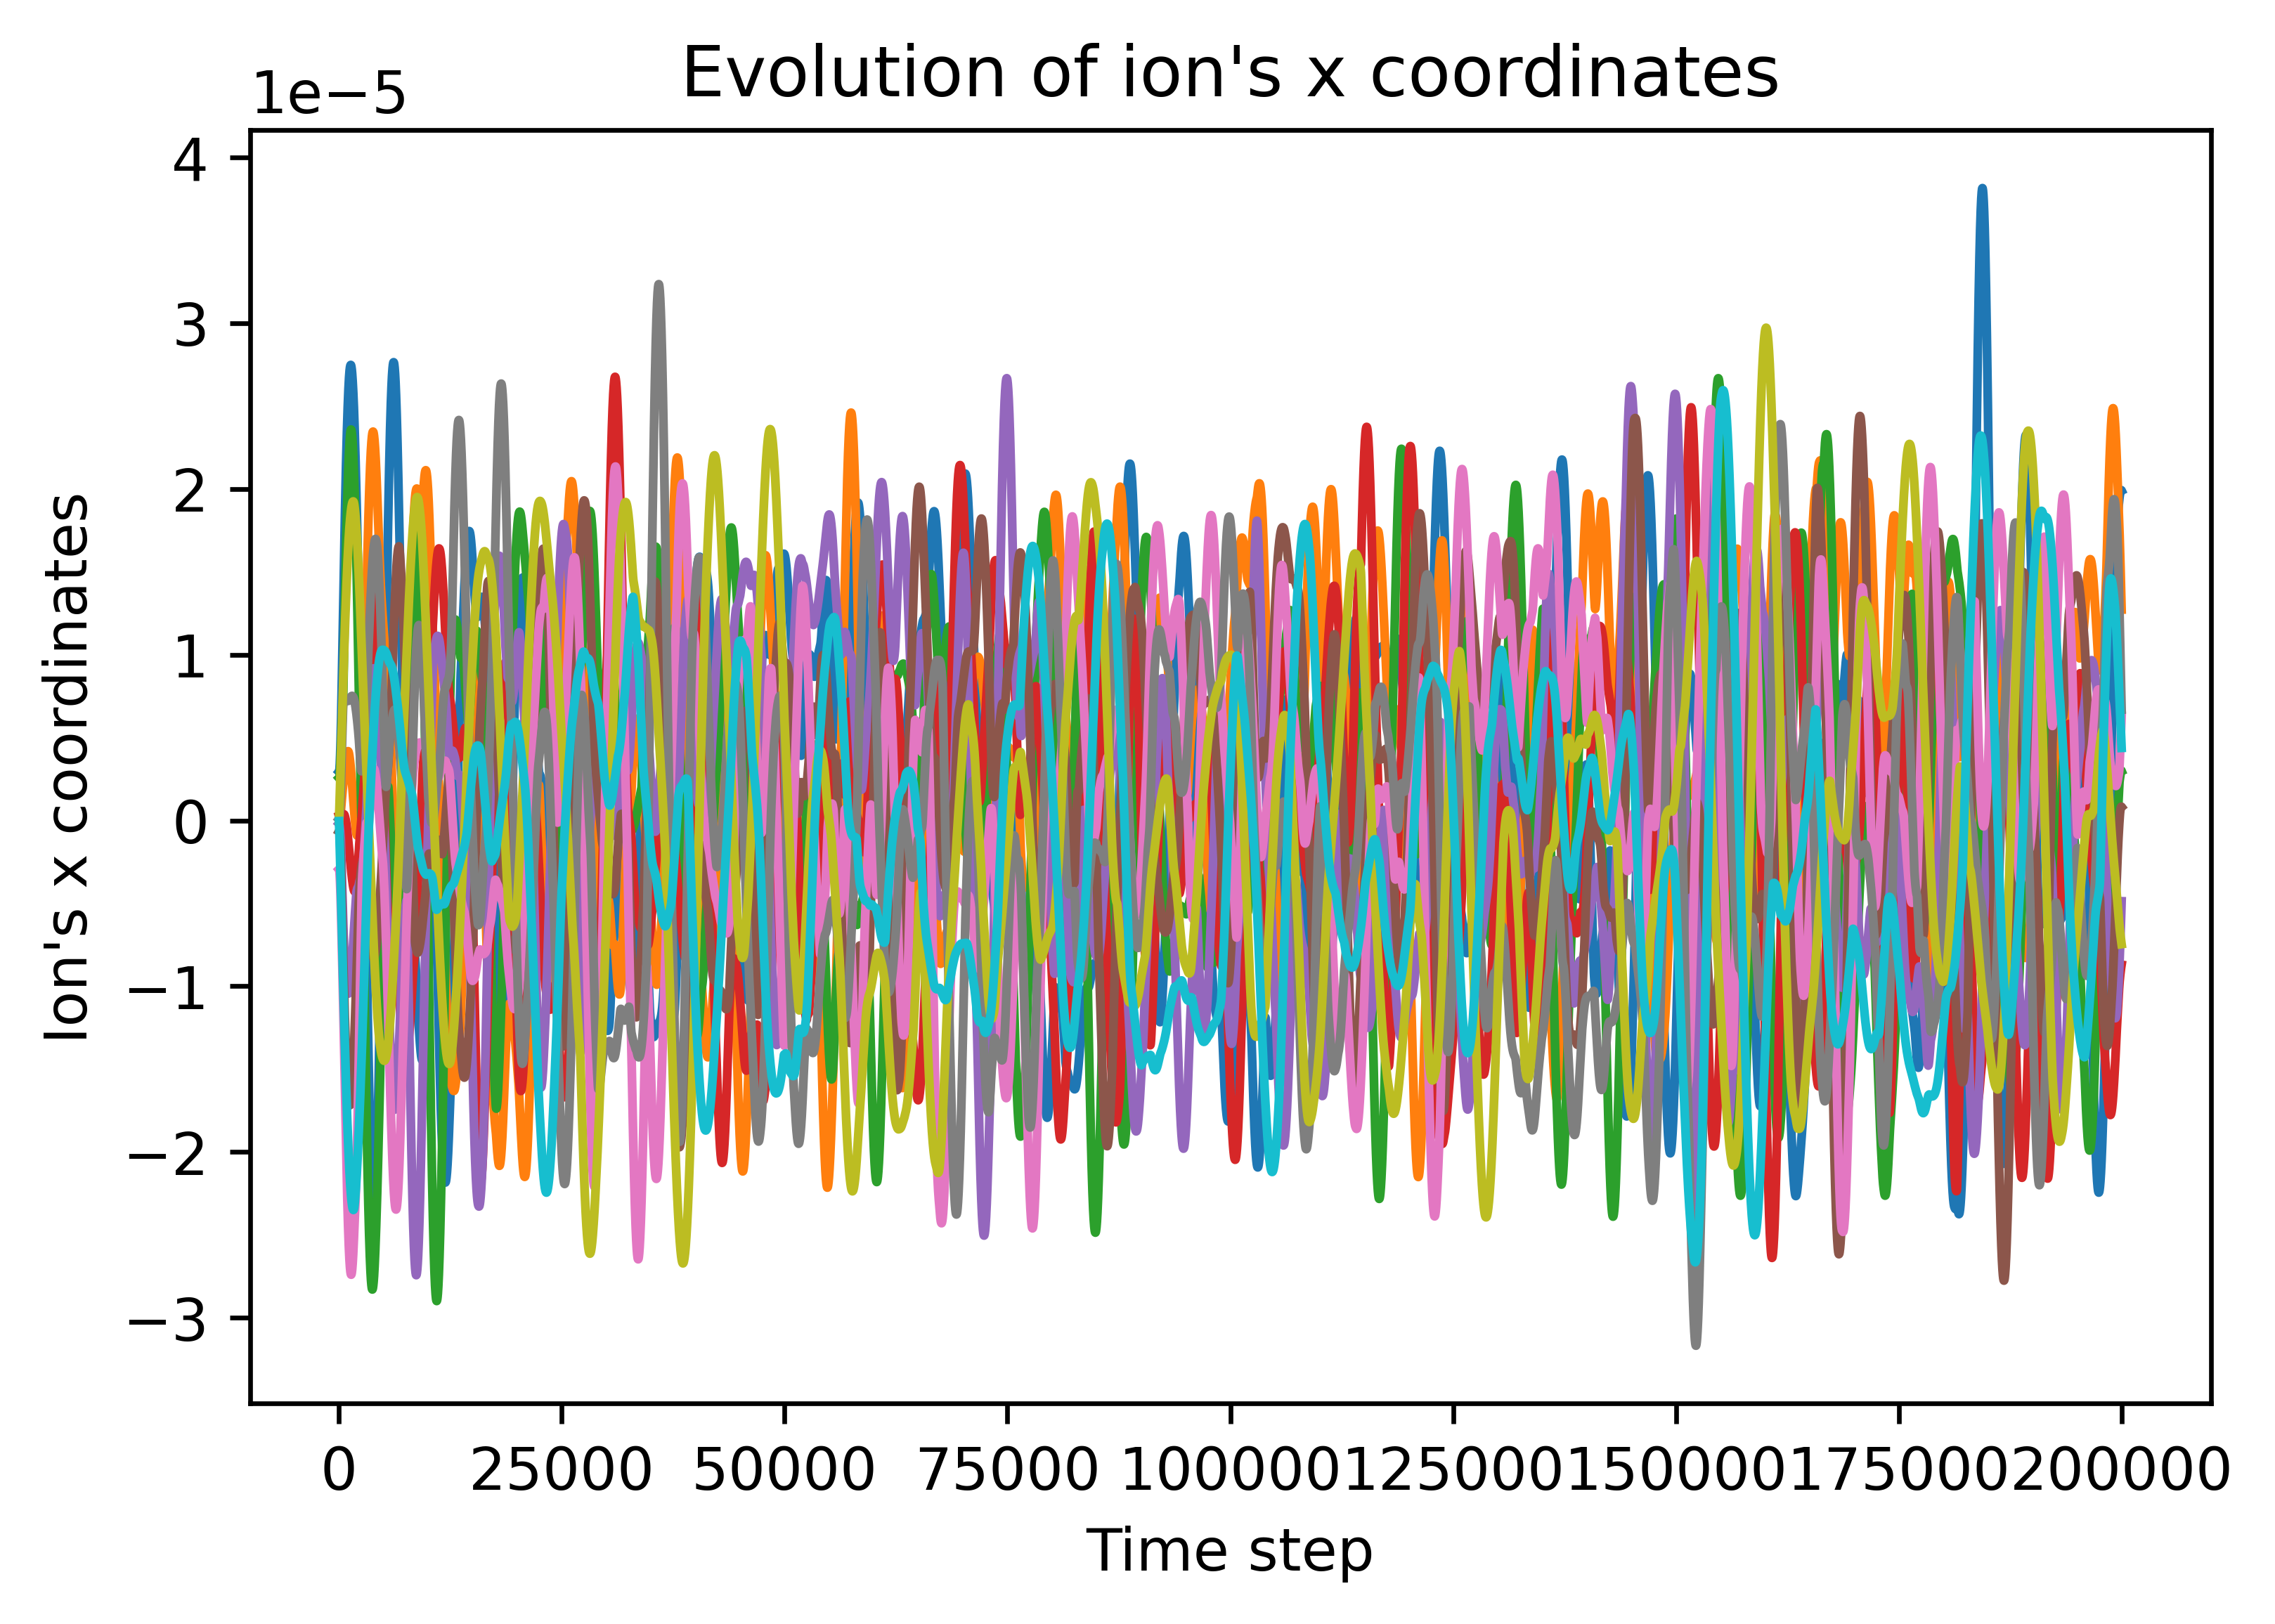

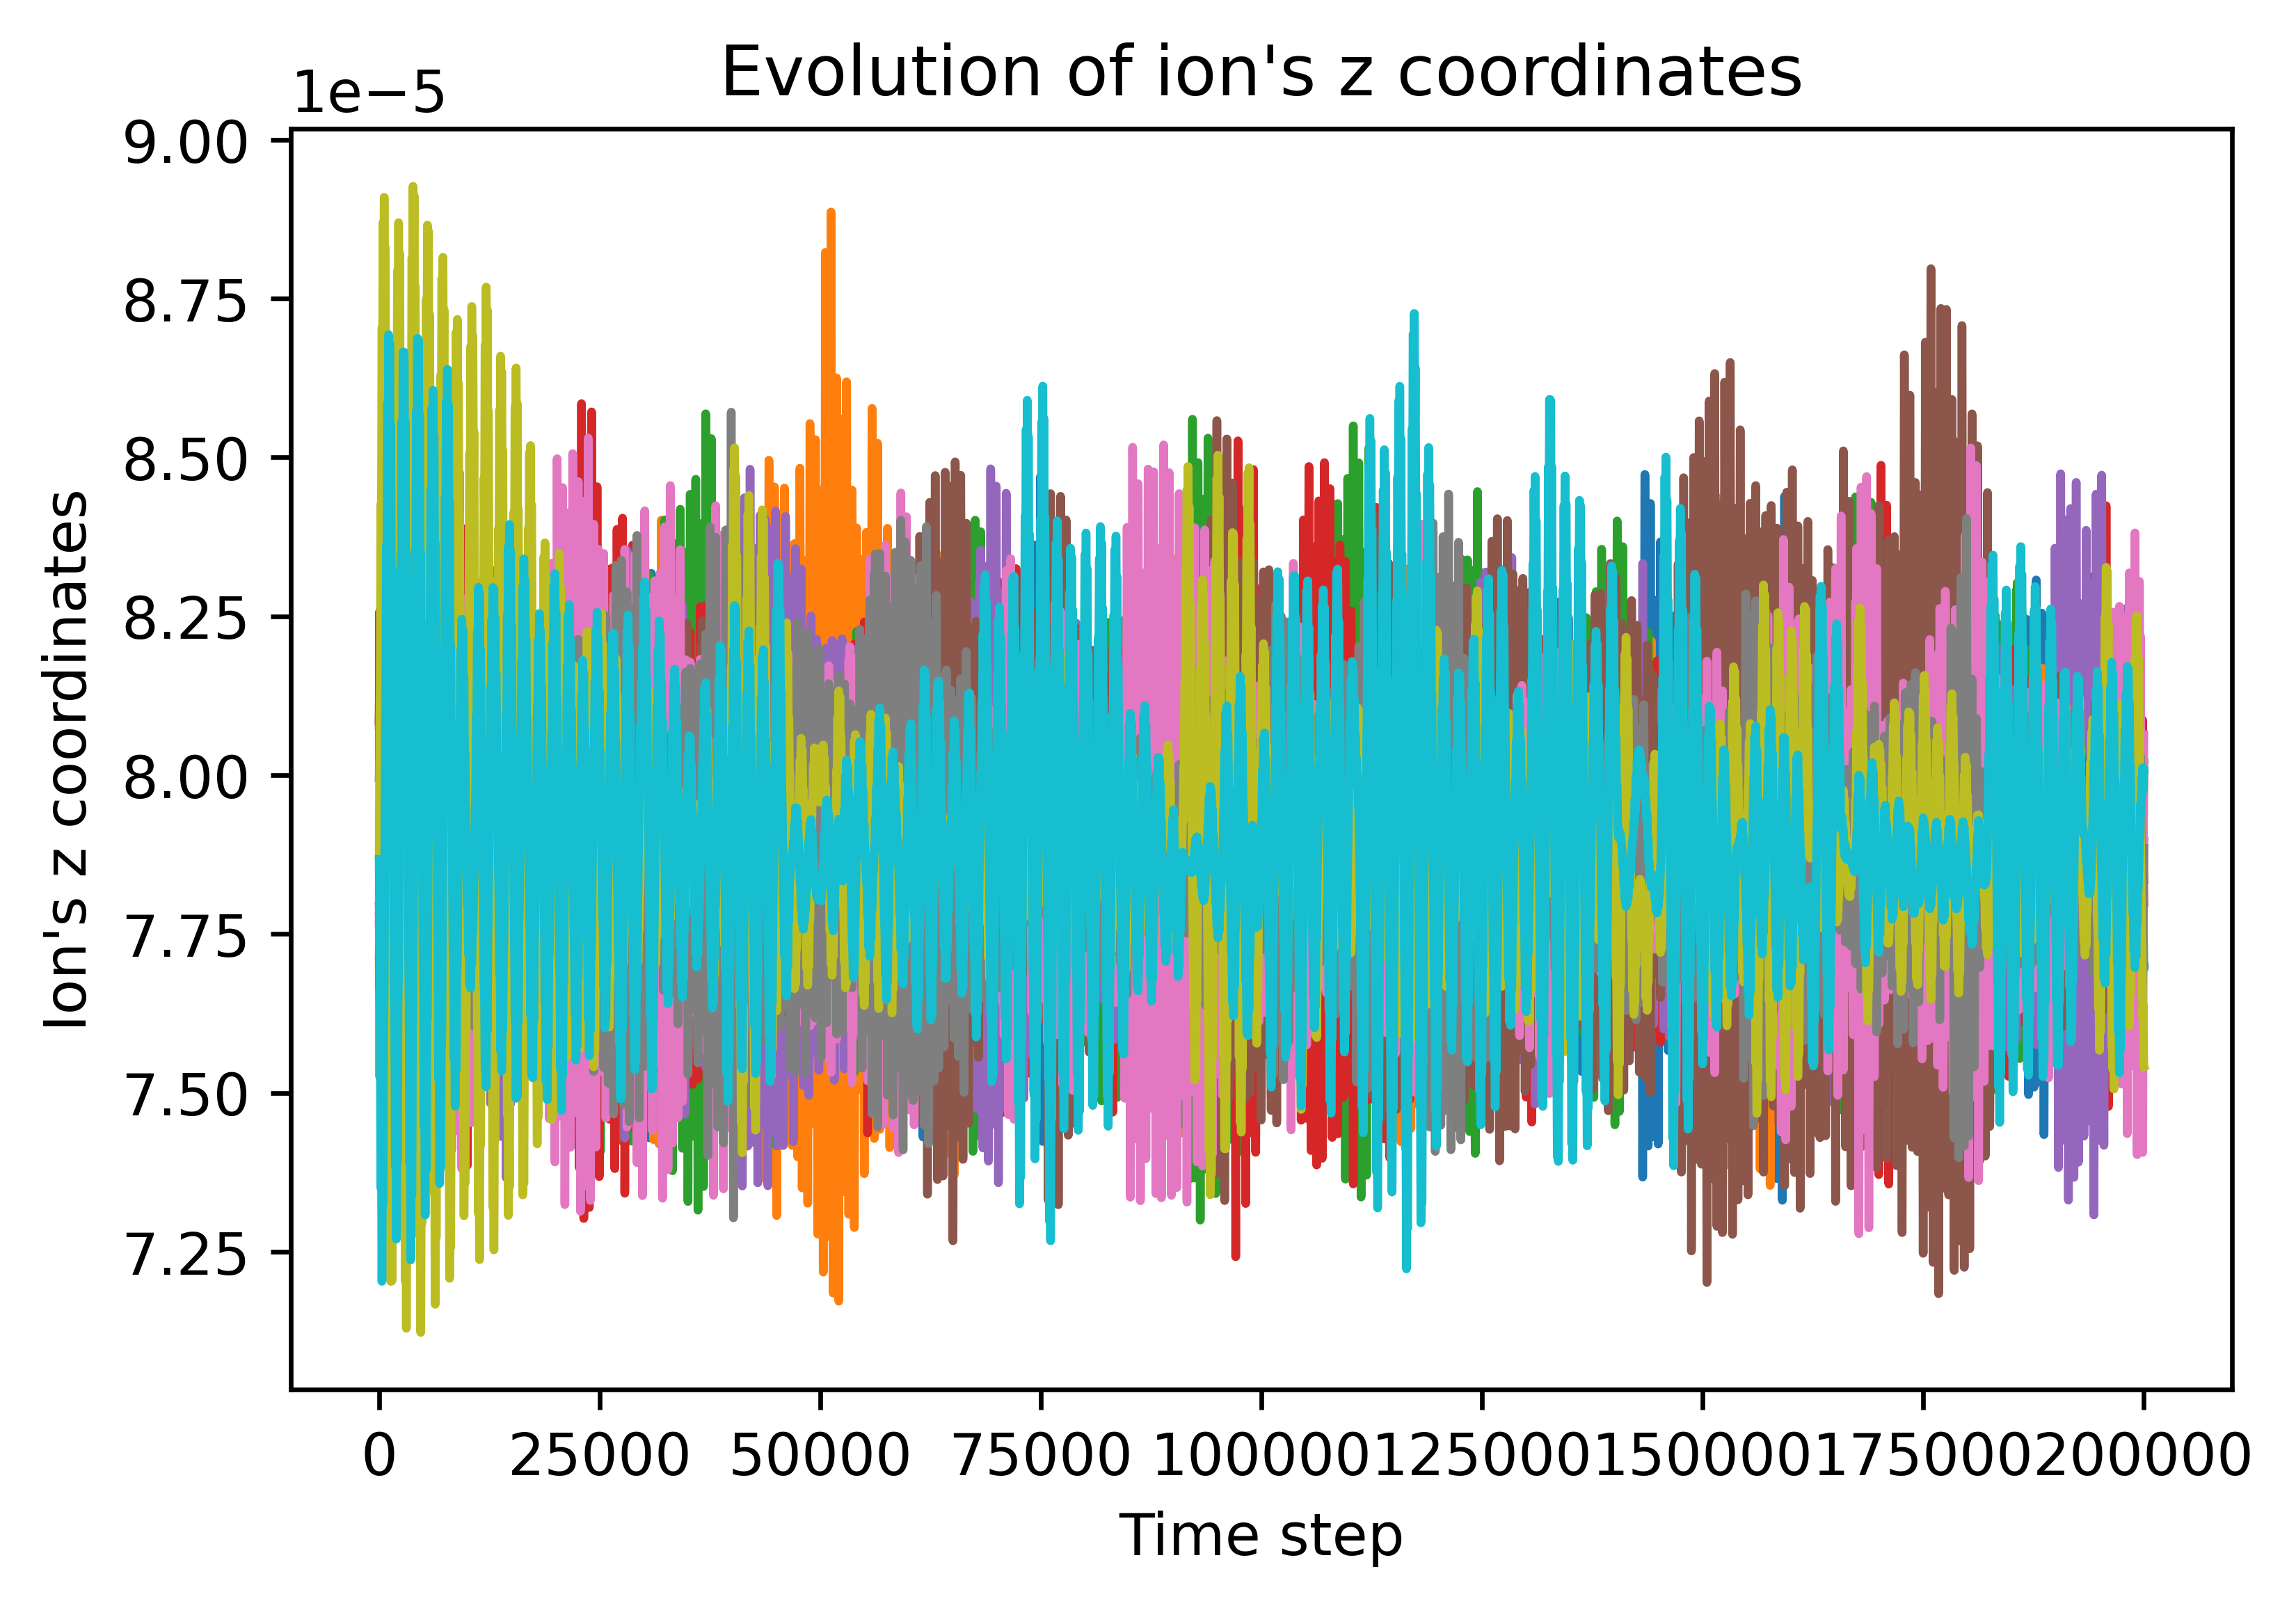

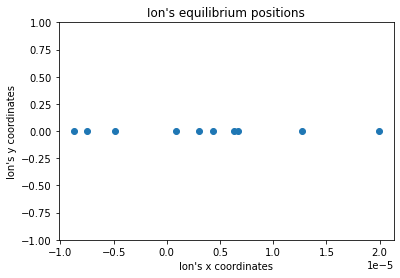

In [5]:
ion_number = Ca_ion_number + Sr_ion_number
_, data = pl.readdump('positions_polygon.txt')

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]
sort = np.argsort(final_x)

ion_positions = np.zeros([ion_number, 3])

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

print('Final ion positions:\n',ion_positions)

# Plot of ion crystal evolution
plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 2])
plt.title('Evolution of ion\'s z coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s z coordinates')
plt.show()

# Plot of the final ion crystal configuration
plt.figure()
plt.scatter(data[-1, :, 0], data[-1, :, 1])
plt.title('Ion\'s equilibrium positions')
plt.xlabel('Ion\'s x coordinates')
plt.ylabel('Ion\'s y coordinates')
plt.ylim([-max(1, 1.2 * np.max(np.abs(data[-1, :, 1]))), max(1, 1.2 * np.max(np.abs(data[-1, :, 1])))])
plt.show()


In [ ]:
##### '''Phonon modes of the ion crystal'''

# Declarations of ion masses and modes for normal modes
ion_masses = [mass for el in range(5)]
omegas = [omega_sec for el in range(5)]
M_matrix = np.diag(list(ion_masses)*3)

#obtaining normal modes, for general case
freqs, modes = sn.normal_modes(ion_positions, omegas, ion_masses)
axial_freqs = freqs[0:5]
radial_freqs = freqs[5:10]
axial_modes = np.zeros([5,5])
for i in range(5):
    for j in range(5):
        axial_modes[i, j] = modes[i][j]
radial_modes = modes[5:10]

"""
Since this is a linear ion chain of 5 ions, just for verification 
I represent these details this way. However, this also works for 
an arbitrary ion crystal of different masses.
"""


print('Axial freqs:', axial_freqs)
print('Radial freqs y:', radial_freqs)

print('Axial modes', axial_modes)

theor_modes = np.array([[0.4472,0.4472,0.4472,0.4472,0.4472],[-0.6395,-0.3017, 0, 0.3017, 0.6395],
               [-0.5377, 0.2805, 0.5143,0.2805, -0.5377], [-0.3017,0.6395,0,-0.6395,0.3017],
               [0.1045,-0.4704,0.7318,-0.4704, 0.1045]])
theor_freqs = np.array([1,3,5.818,9.332,13.47])
freqs = np.sqrt(theor_freqs)*omega_sec[0]
print('Theor freqs', freqs*1e-6)
print('Difference in freqs', np.abs(freqs-axial_freqs)*1e-6)
dif = axial_modes - theor_modes
diff = np.zeros(5)
for i in range(5):
    diff[i] = np.linalg.norm(dif[i])
print('Difference in vectors', diff)
print('If the difference is 2, then the mode just flipped a sign.')

plt.figure(figsize=(4, 6))
plt.plot([], [], color='red', label='radial', linewidth=0.5)
plt.plot([], [], color='blue', label='axial', linewidth=0.5)

for omega in radial_freqs:
    plt.plot([-1, 0], [omega / omega_sec[1], omega / omega_sec[1]], color='red', linewidth=0.5)
for omega in axial_freqs:
    plt.plot([-1, 0], [omega / omega_sec[1], omega / omega_sec[1]], color='blue', linewidth=0.5)

plt.ylabel('$\omega/\omega_{\mathrm{com}}^{\mathrm{rad}}$')
plt.xticks([])
plt.xlim(-1, 2)
plt.ylim(ymin=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(axial_modes[::-1, :] / np.max(np.abs(axial_modes)), cmap='bwr')
plt.colorbar()
plt.xlabel('ion number')
plt.ylabel('mode number')
plt.tight_layout()
plt.show() 